# Proyek Pertama: Membuat Model NLP dengan TensorFlow

Dataset yang digunakan dalam project ini adalah IMDB Dataset yang dapat diunduh pada [tautan](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) ini.

In [20]:
!nvidia-smi

Sun Dec 10 15:52:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0    33W /  70W |    761MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
import re
import pandas as pd
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [23]:
def remove_tags_for_sentence(string):
    removelist = ""
    result = re.sub('','',string)
    result = re.sub('<br />', '', result)
    result = result.lower()
    return result
df['review']=df['review'].apply(lambda x : remove_tags_for_sentence(x))

In [24]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. the filming tec...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


In [25]:
stop_words = set(stopwords.words('english'))
df['review'] = df['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [26]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_kalimat(text):
    kalimat = ""
    for w in w_tokenizer.tokenize(text):
        kalimat = kalimat + lemmatizer.lemmatize(w) + " "
    return kalimat
df['review'] = df.review.apply(lemmatize_kalimat)
df

,review,sentiment
0,one reviewer mentioned watching 1 oz episode h...,positive
1,wonderful little production. filming technique...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there's family little boy (jake) thi...,negative
4,"petter mattei's ""love time money"" visually stu...",positive
...,...,...
49995,thought movie right good job. creative origina...,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,catholic taught parochial elementary school nu...,negative
49998,i'm going disagree previous comment side malti...,negative


In [27]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

In [28]:
sentiment_count_all= df['sentiment'].value_counts()
print("Labels Counts:")
print(sentiment_count_all)

train_sentiment_counts = y_train.value_counts()
print("\nTraining Set Sentiment Counts:")
print(train_sentiment_counts)

test_sentiment_counts = y_test.value_counts()
print("\nTesting Set Sentiment Counts:")
print(test_sentiment_counts)


Labels Counts:
positive    25000
negative    25000
Name: sentiment, dtype: int64

Training Set Sentiment Counts:
negative    20039
positive    19961
Name: sentiment, dtype: int64

Testing Set Sentiment Counts:
positive    5039
negative    4961
Name: sentiment, dtype: int64


In [29]:
encoder = LabelEncoder()
encoded_y_train = encoder.fit_transform(y_train)
encoded_y_test = encoder.fit_transform(y_test)

In [30]:
tokenizer = Tokenizer(num_words = 3000, oov_token='x')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(
    train_sequences,
    padding='post',
    maxlen=200,
    truncating='post'
)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(
    test_sequences,
    padding='post',
    maxlen=200,
    truncating='post'
)

In [31]:
model = keras.Sequential([
    keras.layers.Embedding(3000, 100, input_length=200),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(48, activation='relu'),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [32]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nAkurasi telah mencapai >95%!")
      self.model.stop_training = True
callbacks = myCallback()

In [33]:
num_epochs = 10
history = model.fit(train_padded,
                    encoded_y_train,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=[callbacks]
                    )

Epoch 1/10
625/625 [==============================] - 18s 23ms/step - loss: 0.4694 - accuracy: 0.7670 - val_loss: 0.3519 - val_accuracy: 0.8511
Epoch 2/10
625/625 [==============================] - 15s 24ms/step - loss: 0.2958 - accuracy: 0.8824 - val_loss: 0.3457 - val_accuracy: 0.8577
Epoch 3/10
625/625 [==============================] - 13s 21ms/step - loss: 0.2529 - accuracy: 0.9003 - val_loss: 0.3380 - val_accuracy: 0.8575
Epoch 4/10
625/625 [==============================] - 13s 21ms/step - loss: 0.2220 - accuracy: 0.9152 - val_loss: 0.3553 - val_accuracy: 0.8479
Epoch 5/10
625/625 [==============================] - 13s 21ms/step - loss: 0.1864 - accuracy: 0.9306 - val_loss: 0.3998 - val_accuracy: 0.8594
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 0.1604 - accuracy: 0.9427 - val_loss: 0.4410 - val_accuracy: 0.8447
Epoch 7/10
625/625 [==============================] - ETA: 0s - loss: 0.1258 - accuracy: 0.9560
Akurasi telah mencapai >95%!
625/625 [==

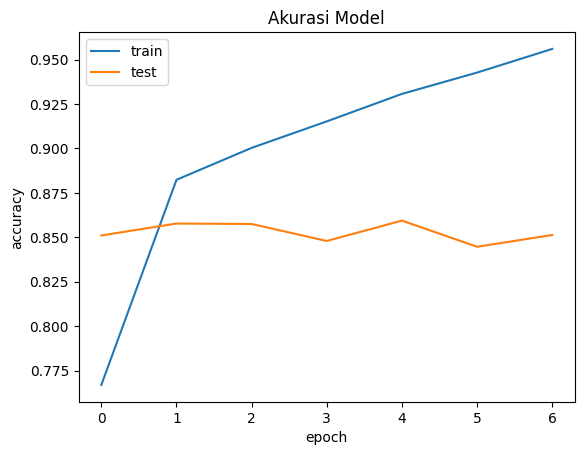

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

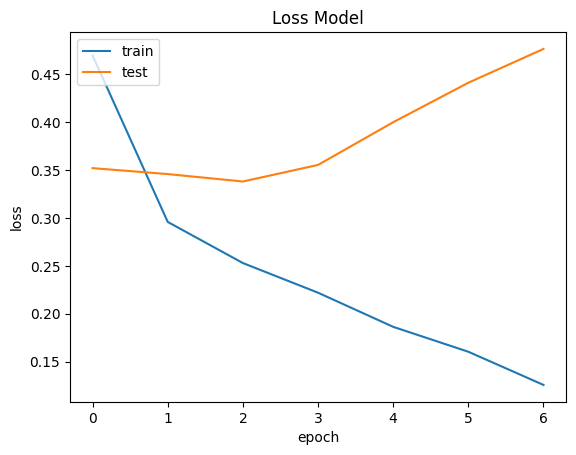

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()